In [11]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,MinMaxScaler
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.model_selection import cross_val_score,RandomizedSearchCV,train_test_split
from sklearn.ensemble import RandomForestClassifier

In [12]:
Titanic_data=pd.read_csv(r'/Users/dumsi/Downloads/titanic/train.csv')
Titanic_data['Title'] = Titanic_data['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
Titanic_data.drop(columns=['Name','Ticket','Cabin','PassengerId'],inplace=True)
Titanic_data.fillna({'Age':Titanic_data['Age'].mean()},inplace=True)
Titanic_data.dropna(inplace=True)
x=Titanic_data.drop(columns='Survived')
y=Titanic_data['Survived']



x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=125)



col_tf=ColumnTransformer([('Sex_to_numerical',OrdinalEncoder(categories=[['female','male']]),['Sex']),
                          ('Embarked_to_numerical',OneHotEncoder(handle_unknown='ignore'),['Embarked']),
                          ('Title_to_numerical',OneHotEncoder(handle_unknown='ignore'),['Title'])],remainder='passthrough')
pip=Pipeline([('column_transformer',col_tf),('scaling',MinMaxScaler())])



x1=pip.fit_transform(x_train)
onehotenco=col_tf.named_transformers_['Embarked_to_numerical'].get_feature_names_out(['Embarked']).tolist()
onehotenco1=col_tf.named_transformers_['Title_to_numerical'].get_feature_names_out(['Title']).tolist()
changed_col=['Sex']+onehotenco+onehotenco1
half_col=[]
for i in x_train.columns:
    if i not in ['Sex','Embarked','Title']:
        half_col.append(i)
final_col=changed_col+half_col 
x_train=pd.DataFrame(x1,columns=final_col,index=x_train.index)



y1=pip.transform(x_test)
x_test=pd.DataFrame(y1,columns=final_col,index=x_test.index)




hyper=[{'n_estimators':list(range(50,100)),'max_depth':list(range(2,20)),'min_samples_leaf':list(range(1,10)),
        'min_samples_split':list(range(10,20))}]       
log=RandomizedSearchCV(RandomForestClassifier(),param_distributions=hyper,cv=5,n_iter=50,scoring='f1',return_train_score=True,random_state=25)
model=log.fit(x_train,y_train)



pred=model.predict(x_train)
f1=f1_score(y_train,pred)
print('train score:',f1)



y_pred=model.predict(x_test)
f11=f1_score(y_test,y_pred)
print('test score:',f11)

train score: 0.8603104212860311
test score: 0.7578947368421053


In [13]:
Titanic_data_test=pd.read_csv(r'/Users/dumsi/Downloads/titanic/test.csv')
Titanic_data_test['Title'] = Titanic_data_test['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

Titanic_data_test.drop(columns=['Name','Ticket','Cabin','PassengerId'],inplace=True)
Titanic_data_test.fillna({'Age':Titanic_data['Age'].mean(),'Fare':x_test['Fare'].mean()},inplace=True)
x_test=Titanic_data_test


x_t=pip.transform(x_test)


x_test=pd.DataFrame(x_t,columns=final_col,index=x_test.index)
x_test

y_pred=model.predict(x_test)
y_pred

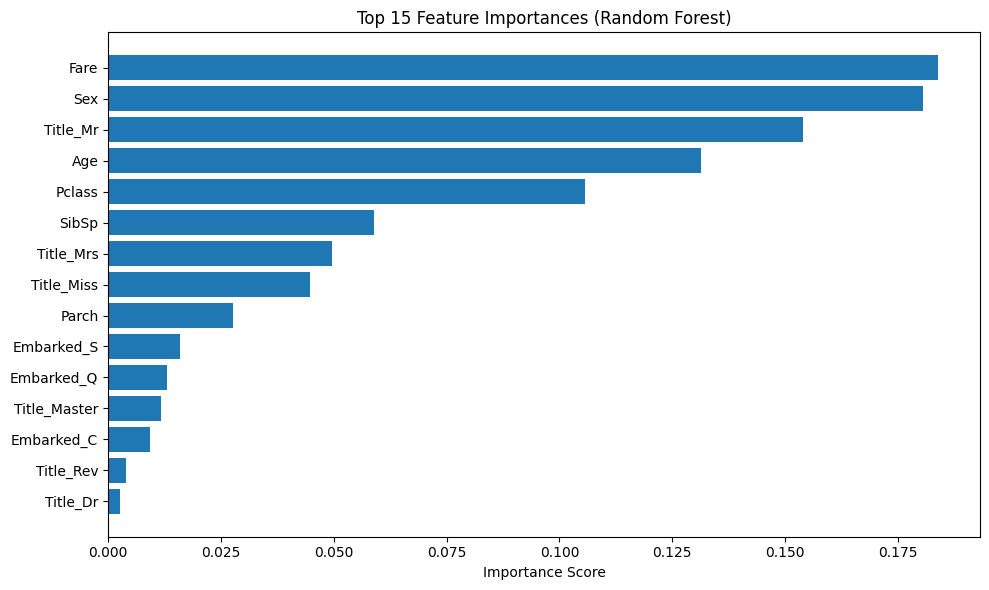

In [15]:
import matplotlib.pyplot as plt

feat_imp = model.best_estimator_.feature_importances_

importance_df = pd.DataFrame({
    'Feature': final_col,
    'Importance': feat_imp
}).sort_values(by='Importance', ascending=False)

top_n = 15
top_features = importance_df.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1]) 
plt.xlabel('Importance Score')
plt.title(f'Top {top_n} Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()
